# 2.4
- Jag vill se ifall vi predikera ifall någon är positiv för cardiovascular disease.
- I detta fallet använder jag df_2, men jag tror att df_1 hade funkat också
- Efter jag hade kollat runt lite på modeller som ska vara bra på kategorisk data kom jag fram till att jag vill testa:
* KNN
* Random Forest
* SVM
* Logistic Regression

### Recall är viktigare eftersom vi vill inte ha false negatives
### Accuracy är viktigare om vi vill ha mindre false positives

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Code for dfs to be correct

In [26]:
df = pd.read_csv("../Labb/Disease_prediction/cardio_train.csv", sep=";")

df["age"] = round(df["age"]/365).astype(int) 

df['BMI'] = df['weight'] / (df['height']/100)**2

# remove outliers that are below 15 and above 50
df = df[df['BMI'] > 15]
df = df[df['BMI'] < 50]

df['BMI'].min(), df['BMI'].max()

df['BMI_category'] = df['BMI'].apply(lambda x: 1 if x < 25 else 2 if x < 30 else 3)

# removing outliers
# set the limits for systolic blood pressure to 90-200 and for diastolic blood pressure to 60-145
# From what I can find, you have hypotension (low blood pressure) if you go below 90/60.
df = df[df['ap_hi'] > 90]
df = df[df['ap_hi'] < 200] # set it to 200 since the next highest recorded value in the dataset is 197 for systolic blood pressure
# and systolic pressure above 180 is potentially life-threatening, which means not alot of people will have a systolic blood pressure above 200

# diastolic blood pressure limits
# From what I can find, you have hypotension (low blood pressure) if you go below 60 diastolic blood pressure.
df = df[df['ap_lo'] > 60]
df = df[df['ap_lo'] < 145] # set the limit to 145 since the highest recorded value in the dataset is 140 for diastolic blood pressure


df = df[df['ap_hi'] > df['ap_lo']] # removes all rows where the diastolic blood pressure is higher than the systolic blood pressure

for index, row in df.iterrows():
    sys_bp = row['ap_hi']
    dia_bp = row['ap_lo']

    new_col = 'BP_category'

    # Categorize the blood pressure according to the standard guidelines from wikipedia
    if sys_bp < 120 and dia_bp < 80:
        df.at[index, new_col] = 1
    elif sys_bp < 130 and dia_bp < 80:
        df.at[index, new_col] = 2
    elif sys_bp < 140 or dia_bp < 90:
        df.at[index, new_col] = 3
    elif sys_bp < 180 or dia_bp < 120:
        df.at[index, new_col] = 4
    elif sys_bp > 180 or dia_bp > 120:
        df.at[index, new_col] = 5

df_1 = df.drop(['ap_hi', 'ap_lo', 'height', 'weight', 'BMI'], axis=1)
df_2 = df.drop(['height', 'weight', 'BMI_category', 'BP_category'], axis=1)

In [27]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,BP_category
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,1,3.0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,3,4.0
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,1,3.0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,2,4.0
5,8,60,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,2,3.0
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,2,3.0
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,3,4.0
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,2,3.0


In [28]:
df_2.drop('id', axis=1, inplace=True) # did not want to keep this column since id is arbitrary and might mess up the model accuracy

In [29]:
from sklearn.model_selection import train_test_split

# splitting the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df_2.drop('cardio', axis=1), df_2['cardio'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)


### Why Scale, Standardize, or Normalize?
- Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. Examples of such algorithm families include:

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# standardizing the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# normalizing the features
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# pretty much no difference between standardizing and normalizing the features both indivudually and together

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# import suport vector machine
from sklearn.svm import SVC


# hyperparameters for SVM
svm_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

# hyperparameters for RF
rf_params = {'max_leaf_nodes': [1, 2, 3], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 10]}

# hyperparameters for KNN
k_neigh_params = {'n_neighbors': [1, 2, 5, 10, 15, 20], 'weights': ['uniform', 'distance'], "metric": ['euclidean', 'manhattan', 'minkowski']}

# hyperparameters for LR
log_reg_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# dictionary of hyperparameters for each model
param_grids = {'KNN': k_neigh_params, 'LR': log_reg_params, 'RF': rf_params, 'SVM': svm_params}

# ran the cell two seperate times, don't wanna rerun it again since it takes about 40 minutes to run
# All scores for the hyperparameters are below

In [32]:
# models = {"KNN": KNeighborsClassifier(), "LR": LogisticRegression(), "RF": RandomForestClassifier(), "SVM": SVC()}

# # performs grid search for each model
# for model_name, model in models.items():
#     grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='accuracy', cv=5)
#     grid.fit(X_train, y_train)
#     print(f"{model_name}: Best Parameters: {grid.best_params_}")
#     print(f"{model_name}: Best Score: {grid.best_score_}")


----------------------------------SVM----------------------------------------------------------------
- Best parameters for SVM: "Gamma": "scale", "kernel": "rbf"
- Tested: "Gamma": ["auto", "scale"]
- Tested: "kernel": ['linear', 'poly', 'rbf', 'sigmoid']

-----------------------------------RF--------------------------------------------------------------
- Best parameters for RF: 'max_depth': 4, 'max_leaf_nodes': 3, 'min_samples_split': 2
- Tested:'max_leaf_nodes': [1, 2, 3]
- Tested:'max_depth': [2, 4, 6]
- Tested: 'min_samples_split': [2, 5, 10]

---------------------------------------LR-----------------------------------------------------------
- Best Parameters: {'penalty': 'l2', 'solver': 'liblinear'}
- Tested: 'penalty': ['l1', 'l2', 'elasticnet', 'none']
- Tested: 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

---------------------------------------KNN-----------------------------------------------------------
- KNN: Best Parameters: 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'
- Tested: k_neigh_params = 'n_neighbors': [1, 2, 5, 10, 15, 20]
- Tested: 'weights': ['uniform', 'distance']
- Tested: "metric": ['euclidean', 'manhattan', 'minkowski']

In [33]:
from sklearn.metrics import accuracy_score

# testing on validation set first
svm = SVC(C=1, kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_val)

rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)

knn = KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_val)


svm_acc = accuracy_score(y_val, svm_preds)
rf_acc = accuracy_score(y_val, rf_preds)
lr_acc = accuracy_score(y_val, lr_preds)
knn_acc = accuracy_score(y_val, knn_preds)

print('SVM Validation Accuracy:', svm_acc)
print('RF Validation Accuracy:', rf_acc)
print('LR Validation Accuracy:', lr_acc)
print('KNN Validation Accuracy:', knn_acc)


SVM Validation Accuracy: 0.7250076585316042
RF Validation Accuracy: 0.7280710711732871
LR Validation Accuracy: 0.7243949760032676
KNN Validation Accuracy: 0.7151026243234964


In [34]:
# predicts on test set
# calculate test accuracy for SVM
svm_test_preds = svm.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
print(f'SVM Test Accuracy: {svm_test_acc}')

# calculate test accuracy for RF
rf_test_preds = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
print(f'RF Test Accuracy: {rf_test_acc}')

# calculate test accuracy for LR
lr_test_preds = lr.predict(X_test)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
print(f'LR Test Accuracy: {lr_test_acc}')

# calculate test accuracy for KNN
knn_test_preds = knn.predict(X_test)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
print(f'KNN Test Accuracy: {knn_test_acc}')

SVM Test Accuracy: 0.7255642937391482
RF Test Accuracy: 0.7270963129404555
LR Test Accuracy: 0.7196404861607599
KNN Test Accuracy: 0.7168828515984067


# 2.5

### Testing combining models 

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      4878
           1       0.76      0.66      0.71      4915

    accuracy                           0.73      9793
   macro avg       0.73      0.73      0.72      9793
weighted avg       0.73      0.73      0.72      9793



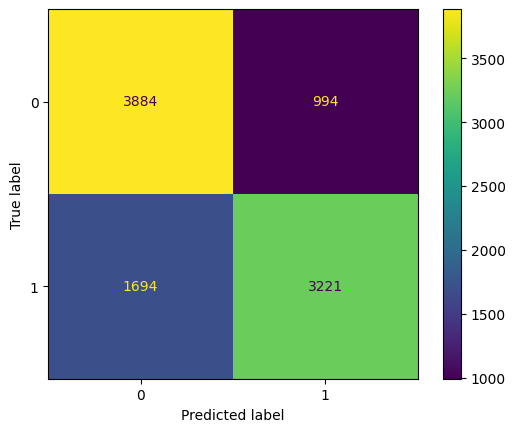

In [35]:
# import votingclassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()

vote_clf = VotingClassifier(
    [("rf", RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)),
     ("svc", SVC(kernel='rbf', gamma='scale')),
        ("knn", KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')),
        ("log_reg", LogisticRegression(penalty='l2', solver='liblinear')),
   #   ("naive_complement", ComplementNB()),
   #   ("naive_bernoulli", BernoulliNB()),
   #   ("naive_multinomail", MultinomialNB())
   ], voting="hard")

evaluate_model(vote_clf)

# Worse result than the best individual model for recall
# 0.01 better recall for 0 and 0.01 worse recall for 1 without naive bayes

# 2.6

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.75      0.67      0.71      4915

    accuracy                           0.73      9793
   macro avg       0.73      0.73      0.72      9793
weighted avg       0.73      0.73      0.72      9793

None
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      4878
           1       0.70      0.68      0.69      4915

    accuracy                           0.69      9793
   macro avg       0.69      0.69      0.69      9793
weighted avg       0.69      0.69      0.69      9793

None


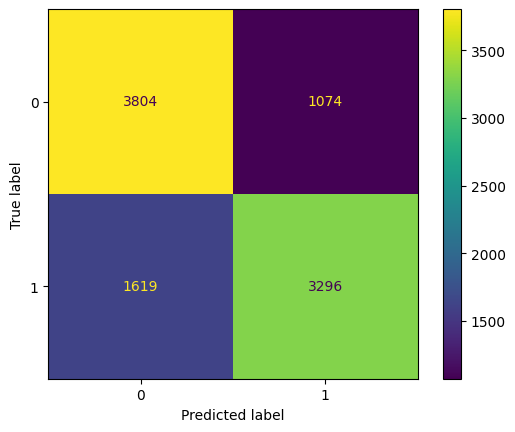

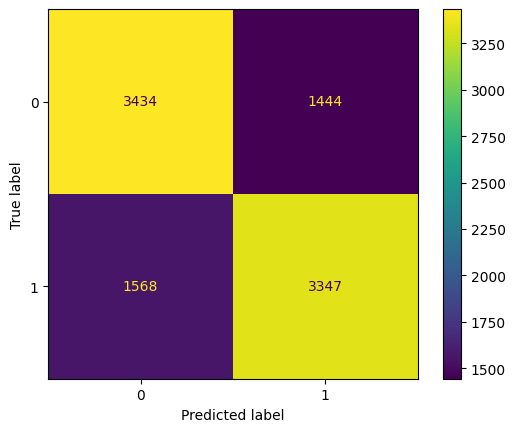

In [36]:
print(evaluate_model(SVC()))
print(evaluate_model(KNeighborsClassifier()))


              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.76      0.67      0.71      4915

    accuracy                           0.72      9793
   macro avg       0.73      0.72      0.72      9793
weighted avg       0.73      0.72      0.72      9793

None
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      4878
           1       0.68      0.69      0.68      4915

    accuracy                           0.68      9793
   macro avg       0.68      0.68      0.68      9793
weighted avg       0.68      0.68      0.68      9793

None


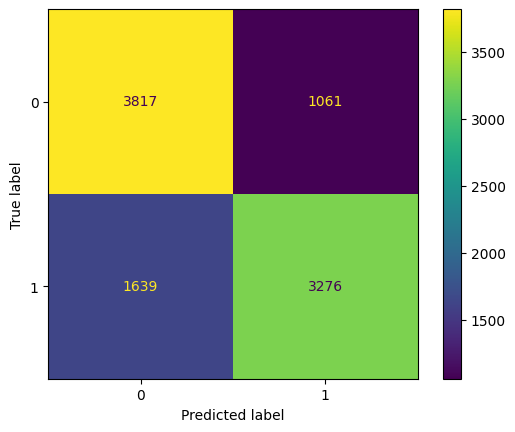

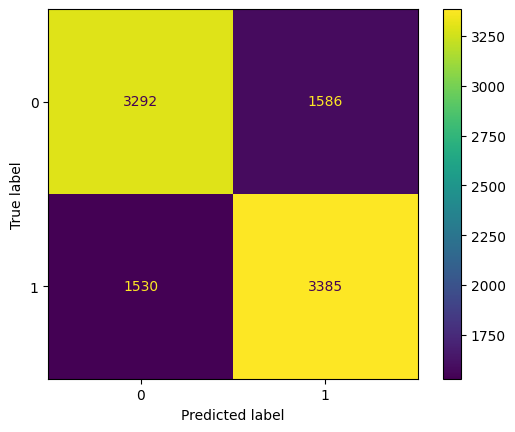

In [37]:
print(evaluate_model(LogisticRegression()))
print(evaluate_model(RandomForestClassifier()))

# 2.7

In [38]:
# pick out 100 random rows from the dataset and export to test_samples.csv
import random

test_samples = random.sample(range(0, len(df_2)), 100)
test_samples_df = df_2.iloc[test_samples]
test_samples_df.to_csv('test_samples.csv', index=False)

# removes the test_samples.csv from the dataset
df_2 = df_2.drop(test_samples_df.index)


In [39]:
test_samples_df

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
11879,46,2,120,80,1,1,1,0,1,1,25.155896
24980,48,1,150,90,2,2,0,0,0,1,40.346505
45939,44,1,130,90,1,1,0,0,0,0,32.323232
64991,42,1,120,80,1,1,0,0,1,0,25.654372
60777,59,1,120,80,2,1,0,0,1,0,31.163435
...,...,...,...,...,...,...,...,...,...,...,...
37487,58,2,160,100,1,3,1,0,1,1,24.221453
54722,52,1,123,77,1,1,0,0,1,0,26.106562
19949,48,1,110,70,1,1,0,0,1,0,21.913806
17482,48,1,120,80,1,1,0,0,1,1,20.904195


In [40]:
# use rf model to train on the dataset
X_train, X_test, y_train, y_test = train_test_split(df_2.drop('cardio', axis=1), df_2['cardio'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)

# save trained model
import pickle

pickle.dump(rf, open('new_rf_model.pkl', 'wb'))

In [41]:
X_train

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
53848,40,1,110,80,3,3,0,0,1,22.656250
68753,49,2,130,70,1,1,0,0,1,37.716263
6771,52,1,130,80,1,1,0,0,1,26.672763
17491,48,2,150,90,2,2,0,0,1,42.458993
58714,54,1,140,90,2,1,0,0,0,23.795360
...,...,...,...,...,...,...,...,...,...,...
67203,64,2,140,90,2,1,0,0,1,20.244898
40972,64,1,140,80,3,3,0,0,0,25.654372
915,62,2,120,80,1,1,0,0,1,26.171875
16944,58,2,140,80,3,1,0,0,1,29.411765


In [42]:
# remove all nan-values from df_2
df = df.dropna()
df_2 = df_2.dropna()

In [43]:
# then save the model to a .pkl-file
import joblib
joblib.dump(rf, 'new_rf.pkl')

['new_rf.pkl']

In [44]:
test_samples_df

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
11879,46,2,120,80,1,1,1,0,1,1,25.155896
24980,48,1,150,90,2,2,0,0,0,1,40.346505
45939,44,1,130,90,1,1,0,0,0,0,32.323232
64991,42,1,120,80,1,1,0,0,1,0,25.654372
60777,59,1,120,80,2,1,0,0,1,0,31.163435
...,...,...,...,...,...,...,...,...,...,...,...
37487,58,2,160,100,1,3,1,0,1,1,24.221453
54722,52,1,123,77,1,1,0,0,1,0,26.106562
19949,48,1,110,70,1,1,0,0,1,0,21.913806
17482,48,1,120,80,1,1,0,0,1,1,20.904195
